# Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
import pickle as pkl
from tqdm import tqdm
import os
import time
from collections import defaultdict
from scipy import stats
from itertools import permutations, product
from numpy.linalg import norm
import seaborn as sns
sns.set(style="darkgrid")
pd.set_option("display.precision", 4)

# Summary

#### Evaluation strategies
We have identified three evaluation strategies:
1. For every user in the **train set** rank **all items**. | Book paper, *eva_one*
2. For every user in the **test set** rank **only the items this user has rated in the test set**. | Music paper, *eva_two*
3. For every user in the **test set** rank **only the items this user has NOT rated in the train set**. | Movie(?) paper, *eva_three*

#### Algorithms

In [2]:
algo_names = ["UserKNN",
              "ItemKNN", 
              "UserKNN with means", 
              "BPR",
              "MF",
              "PMF",
              "NMF",
              "WMF",
              "HPF",
              "NeuMF",
              "VAECF"
              ] # in the order that they are in the model list

# Import results

### Additions

In [3]:
data = ["movies", "music","books"]
evaluation = ["eva_one", "eva_two", "eva_three"]
pop_notion = ["pop_one", "pop_two", "pop_three"]

In [4]:
aspects = [data, evaluation, pop_notion]

In [5]:
some_aspects = [data, evaluation]

In [6]:
results_location = "data/results/"

In [7]:
# pkl.load(open(results_location+"df_item_dist_cornac_"+data[2]+"_"+evaluation[0]+".csv","rb"))

In [8]:
c = pd.read_csv(results_location+"df_item_dist_cornac_"+data[2]+"_"+evaluation[0]+".csv", index_col=0)

In [9]:
c2 = pd.read_csv(results_location+"df_item_dist_cornac_"+data[2]+"_"+evaluation[1]+".csv", index_col=0)

In [10]:
stats.pearsonr(c2["count"], c2.HPF)

(0.9173785262794713, 0.0)

In [11]:
stats.pearsonr(c2["count"], c2.NMF)

(0.912428111655027, 0.0)

In [12]:
stats.pearsonr(c["count"], c.NMF)

(-0.03643678357239851, 0.0024315820834822366)

### Define aspect combinations

In [13]:
all_combinations = list(product(*aspects))
all_combinations = [x for x in all_combinations if not ("movies" in x)&("pop_three" in x)]
all_combinations = [x for x in all_combinations if not ("books" in x)&("pop_three" in x)]
# remove combinations of "pop_three" that dont include music.
some_combinations = list(product(*some_aspects))

In [14]:
sum_exists = 0
for combi in some_combinations:
    path = results_location+"df_item_dist_cornac_"+combi[0]+"_"+combi[1]+".csv"
    exists = os.path.exists(path)
    print(combi, exists)
    sum_exists+=exists
print(sum_exists, "out of", len(some_combinations))

('movies', 'eva_one') True
('movies', 'eva_two') True
('movies', 'eva_three') True
('music', 'eva_one') True
('music', 'eva_two') True
('music', 'eva_three') True
('books', 'eva_one') True
('books', 'eva_two') True
('books', 'eva_three') True
9 out of 9


In [15]:
sum_exists = 0

for combi in all_combinations:
    path = results_location+"low_gap_vals_"+combi[0]+"_"+combi[1]+"_"+combi[2]+".pickle"
    exists = os.path.exists(path)
    sum_exists+=exists
    print(combi, "|",exists)
print(sum_exists, "out of", len(all_combinations))

('movies', 'eva_one', 'pop_one') | True
('movies', 'eva_one', 'pop_two') | True
('movies', 'eva_two', 'pop_one') | True
('movies', 'eva_two', 'pop_two') | True
('movies', 'eva_three', 'pop_one') | True
('movies', 'eva_three', 'pop_two') | True
('music', 'eva_one', 'pop_one') | True
('music', 'eva_one', 'pop_two') | True
('music', 'eva_one', 'pop_three') | True
('music', 'eva_two', 'pop_one') | True
('music', 'eva_two', 'pop_two') | True
('music', 'eva_two', 'pop_three') | True
('music', 'eva_three', 'pop_one') | True
('music', 'eva_three', 'pop_two') | True
('music', 'eva_three', 'pop_three') | True
('books', 'eva_one', 'pop_one') | True
('books', 'eva_one', 'pop_two') | True
('books', 'eva_two', 'pop_one') | True
('books', 'eva_two', 'pop_two') | True
('books', 'eva_three', 'pop_one') | True
('books', 'eva_three', 'pop_two') | True
21 out of 21


# First RQ

## Calculate correlations

### Books

In [26]:
books_corr = pd.DataFrame(columns=evaluation, index = algo_names).fillna(0)

In [29]:
for combi in some_combinations:
    if "books" in combi:
        eva_str = combi[1]
        df = pd.read_csv(results_location+"df_item_dist_cornac_"+combi[0]+"_"+eva_str+".csv", index_col=0)
        profile_pop = df["count"]
        for algorithm in algo_names:
            rec_pop = df[algorithm]
            correlation, _ = stats.pearsonr(profile_pop, rec_pop)
            books_corr.loc[algorithm, eva_str] = correlation

In [30]:
books_corr

,eva_one,eva_two,eva_three
UserKNN,0.0407,0.9121,0.0385
ItemKNN,0.7249,0.9115,0.7275
UserKNN with means,0.0454,0.9105,0.0421
BPR,0.4554,0.9208,0.4626
MF,0.0507,0.9105,0.0498
PMF,0.1454,0.9142,0.1406
NMF,-0.0364,0.9124,-0.0365
WMF,0.8312,0.9195,0.8304
HPF,0.8362,0.9174,0.8410
NeuMF,0.4202,0.9209,0.4244


In [31]:
with open("latex_tables/book_correlations.tex", "w") as tf:
    tf.write(books_corr.to_latex())

### Movies

In [32]:
movies_corr = pd.DataFrame(columns= evaluation, index =algo_names).fillna(0)

In [33]:
for combi in some_combinations:
    if "movies" in combi:
        eva_str = combi[1]
        df = pd.read_csv(results_location+"df_item_dist_cornac_"+combi[0]+"_"+eva_str+".csv", index_col=0)
        profile_pop = df["count"]
        for algorithm in algo_names:
            rec_pop = df[algorithm]
            correlation, _ = stats.pearsonr(profile_pop, rec_pop)
            movies_corr.loc[algorithm, eva_str] = correlation

In [34]:
movies_corr

,eva_one,eva_two,eva_three
UserKNN,-0.0373,0.7913,-0.0375
ItemKNN,-0.0261,0.9028,-0.0439
UserKNN with means,-0.0821,0.8012,-0.0838
BPR,0.4121,0.8448,0.4818
MF,0.1685,0.8841,0.1080
PMF,0.3429,0.8399,0.2761
NMF,-0.0456,0.7977,-0.0474
WMF,0.3313,0.8114,0.3656
HPF,0.6524,0.8928,0.7535
NeuMF,0.4864,0.8652,0.5657


In [35]:
with open("latex_tables/movie_correlations.tex", "w") as tf:
    tf.write(movies_corr.to_latex())

### Music

In [36]:
music_corr = pd.DataFrame(columns = evaluation, index=algo_names).fillna(0)

In [37]:
for combi in some_combinations:
    if "music" in combi:
        eva_str = combi[1]
        df = pd.read_csv(results_location+"df_item_dist_cornac_"+combi[0]+"_"+eva_str+".csv", index_col=0)
        profile_pop = df["count"]
        for algorithm in algo_names:
            rec_pop = df[algorithm]
            correlation, _ = stats.pearsonr(profile_pop, rec_pop)
            music_corr.loc[algorithm, eva_str] = correlation

In [38]:
music_corr

,eva_one,eva_two,eva_three
UserKNN,0.0537,0.6586,-0.0170
ItemKNN,0.5614,0.8881,-0.0178
UserKNN with means,0.1821,0.6732,-0.0259
BPR,0.3823,0.8192,0.4556
MF,-0.0001,0.9039,-0.0034
PMF,-0.0081,0.6223,-0.0083
NMF,-0.0412,0.7565,-0.0413
WMF,0.2999,0.8191,0.2621
HPF,0.5819,0.8390,0.6836
NeuMF,0.4844,0.8385,0.5586


In [39]:
with open("latex_tables/music_correlations.tex", "w") as tf:
    tf.write(music_corr.to_latex())

## Calculate item coverage

### Books

In [40]:
books_cov = pd.DataFrame(columns=evaluation, index = algo_names).fillna(0)

In [41]:
for combi in some_combinations:
    if "books" in combi:
        eva_str = combi[1]
        df = pd.read_csv(results_location+"df_item_dist_cornac_"+combi[0]+"_"+eva_str+".csv", index_col=0)
        #profile_pop = df["count"]
        for algorithm in algo_names:
            rec_pop = df[algorithm]
            pers = sum(df[algorithm]>0)/len(df)
            books_cov.loc[algorithm, eva_str] = pers

In [42]:
books_cov

,eva_one,eva_two,eva_three
UserKNN,0.2672,0.8130,0.2588
ItemKNN,0.9835,0.8138,0.9766
UserKNN with means,0.3658,0.8148,0.3569
BPR,0.0014,0.7992,0.0023
MF,0.2177,0.8152,0.1608
PMF,0.0673,0.8103,0.0657
NMF,0.2237,0.8138,0.2137
WMF,0.8951,0.8047,0.7180
HPF,0.0714,0.8067,0.0923
NeuMF,0.0014,0.8000,0.0023


In [43]:
with open("latex_tables/book_coverage.tex", "w") as tf:
    tf.write(books_cov.to_latex())

### Movies

In [44]:
movies_cov = pd.DataFrame(columns=evaluation, index = algo_names).fillna(0)

In [45]:
for combi in some_combinations:
    if "movies" in combi:
        eva_str = combi[1]
        df = pd.read_csv(results_location+"df_item_dist_cornac_"+combi[0]+"_"+eva_str+".csv", index_col=0)
        #profile_pop = df["count"]
        for algorithm in algo_names:
            rec_pop = df[algorithm]
            pers = sum(df[algorithm]>0)/len(df)
            movies_cov.loc[algorithm, eva_str] = pers

In [46]:
movies_cov

,eva_one,eva_two,eva_three
UserKNN,0.0124,0.6654,0.0108
ItemKNN,0.5229,0.6832,0.4509
UserKNN with means,0.0688,0.6805,0.0618
BPR,0.0216,0.5901,0.0586
MF,0.5982,0.7337,0.5990
PMF,0.2415,0.6786,0.2515
NMF,0.1012,0.6646,0.1012
WMF,0.0157,0.5923,0.0229
HPF,0.1058,0.6141,0.1743
NeuMF,0.0583,0.5947,0.1033


In [47]:
with open("latex_tables/movie_coverage.tex", "w") as tf:
    tf.write(movies_cov.to_latex())

### Music

In [48]:
music_cov = pd.DataFrame(columns=evaluation, index = algo_names).fillna(0)

In [49]:
for combi in some_combinations:
    if "music" in combi:
        eva_str = combi[1]
        df = pd.read_csv(results_location+"df_item_dist_cornac_"+combi[0]+"_"+eva_str+".csv", index_col=0)
        #profile_pop = df["count"]
        for algorithm in algo_names:
            rec_pop = df[algorithm]
            pers = sum(df[algorithm]>0)/len(df)
            music_cov.loc[algorithm, eva_str] = pers

In [50]:
music_cov

,eva_one,eva_two,eva_three
UserKNN,0.0796,0.3773,0.0403
ItemKNN,0.6686,0.7338,0.7097
UserKNN with means,0.1422,0.5031,0.0694
BPR,0.0094,0.2065,0.0177
MF,0.0008,0.7095,0.0351
PMF,0.0009,0.2983,0.0009
NMF,0.0133,0.5489,0.0144
WMF,0.1981,0.4063,0.2062
HPF,0.0383,0.3407,0.0878
NeuMF,0.0213,0.2332,0.0356


In [51]:
with open("latex_tables/music_coverage.tex", "w") as tf:
    tf.write(music_cov.to_latex())

## Combine tables

In [52]:
movies_corr.columns = ["eva_one_corr", "eva_two_corr", "eva_three_corr"]
music_corr.columns = ["eva_one_corr", "eva_two_corr", "eva_three_corr"]
books_corr.columns = ["eva_one_corr", "eva_two_corr", "eva_three_corr"]

In [53]:
movies_cov.columns = ["eva_one_cov", "eva_two_cov", "eva_three_cov"]
music_cov.columns = ["eva_one_cov", "eva_two_cov", "eva_three_cov"]
books_cov.columns = ["eva_one_cov", "eva_two_cov", "eva_three_cov"]

In [54]:
combined_movies = pd.concat([movies_corr, movies_cov], axis=1)[["eva_one_corr","eva_one_cov","eva_two_corr", "eva_two_cov", 
                                             "eva_three_corr", "eva_three_cov"]]
combined_music = pd.concat([music_corr, music_cov], axis=1)[["eva_one_corr","eva_one_cov","eva_two_corr", "eva_two_cov", 
                                             "eva_three_corr", "eva_three_cov"]]
combined_books = pd.concat([books_corr, books_cov], axis=1)[["eva_one_corr","eva_one_cov","eva_two_corr", "eva_two_cov", 
                                             "eva_three_corr", "eva_three_cov"]]

In [55]:
combined_movies = combined_movies.append(pd.Series(combined_movies.mean(), name="mean"))
combined_music = combined_music.append(pd.Series(combined_music.mean(), name="mean"))
combined_books = combined_books.append(pd.Series(combined_books.mean(), name="mean"))

In [56]:
with open("latex_tables/movies_combined_update.tex", "w") as tf:
    tf.write(combined_movies.to_latex())
with open("latex_tables/music_combined_update.tex", "w") as tf:
    tf.write(combined_music.to_latex())
with open("latex_tables/books_combined_update.tex", "w") as tf:
    tf.write(combined_books.to_latex())

In [57]:
combined_movies

,eva_one_corr,eva_one_cov,eva_two_corr,eva_two_cov,eva_three_corr,eva_three_cov
UserKNN,-0.0373,0.0124,0.7913,0.6654,-0.0375,0.0108
ItemKNN,-0.0261,0.5229,0.9028,0.6832,-0.0439,0.4509
UserKNN with means,-0.0821,0.0688,0.8012,0.6805,-0.0838,0.0618
BPR,0.4121,0.0216,0.8448,0.5901,0.4818,0.0586
MF,0.1685,0.5982,0.8841,0.7337,0.1080,0.5990
PMF,0.3429,0.2415,0.8399,0.6786,0.2761,0.2515
NMF,-0.0456,0.1012,0.7977,0.6646,-0.0474,0.1012
WMF,0.3313,0.0157,0.8114,0.5923,0.3656,0.0229
HPF,0.6524,0.1058,0.8928,0.6141,0.7535,0.1743
NeuMF,0.4864,0.0583,0.8652,0.5947,0.5657,0.1033


## Plot per algorithm

In [58]:
data_dict = {"movies":"MovieLens1M", "music":"LastFM", "books":"Book-Crossing"}
eva_dict = {"eva_one":"Mod.TrainItems", "eva_two":"UserTest", "eva_three":"TrainItems"}

In [59]:
import matplotlib

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

In [60]:
len(algo_names)

11

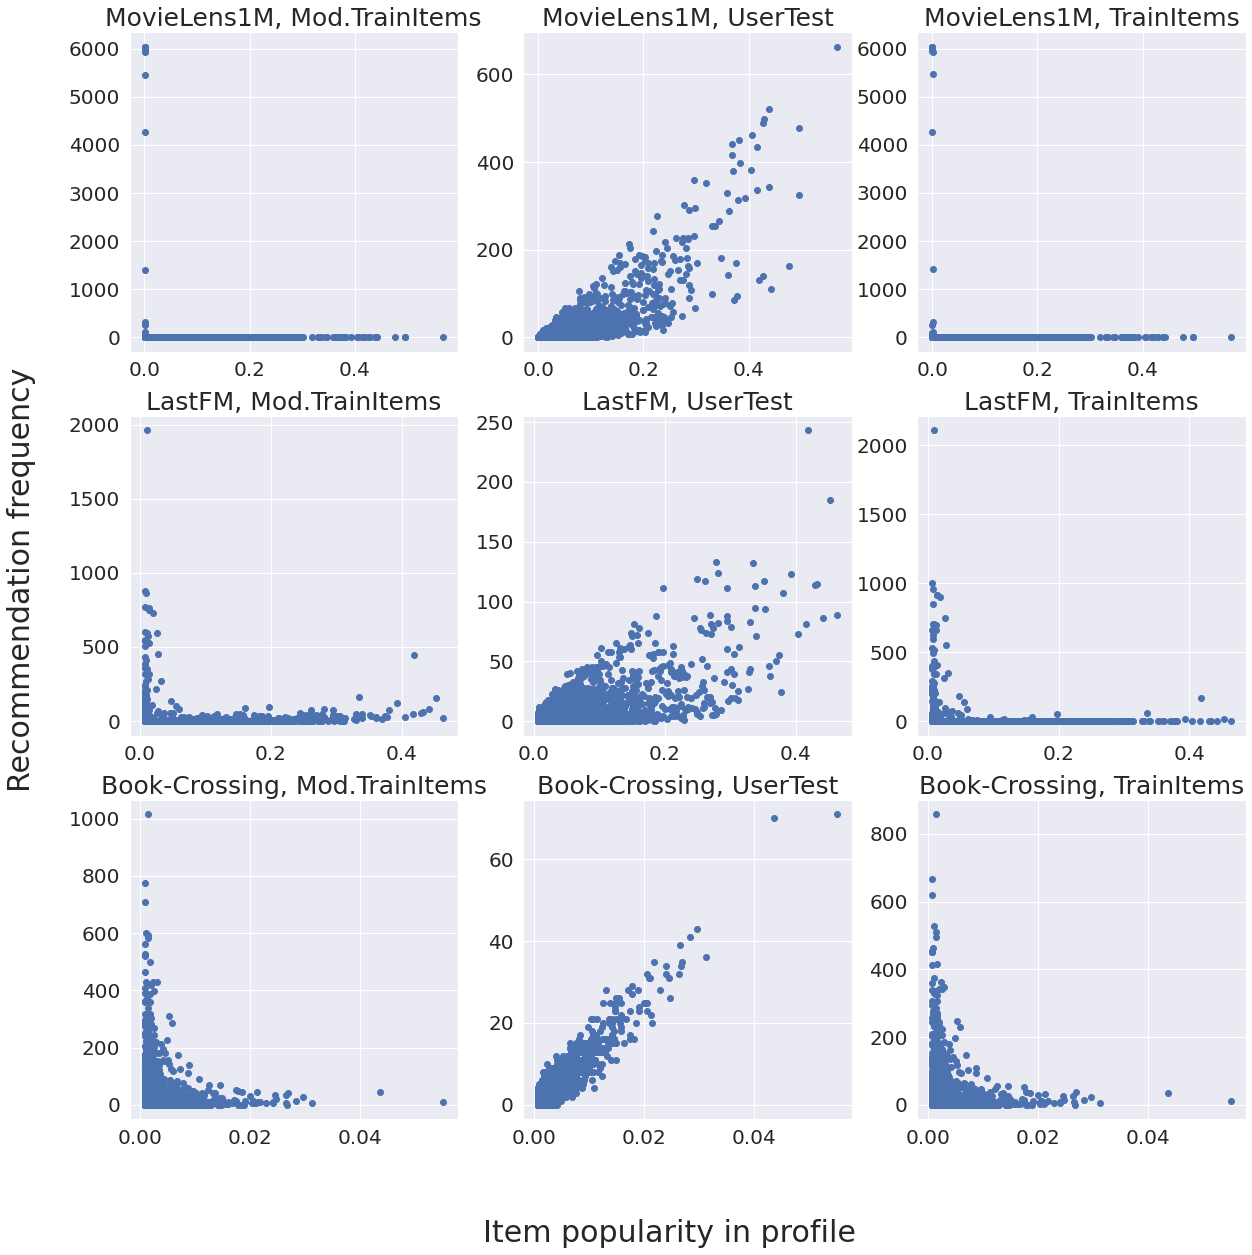

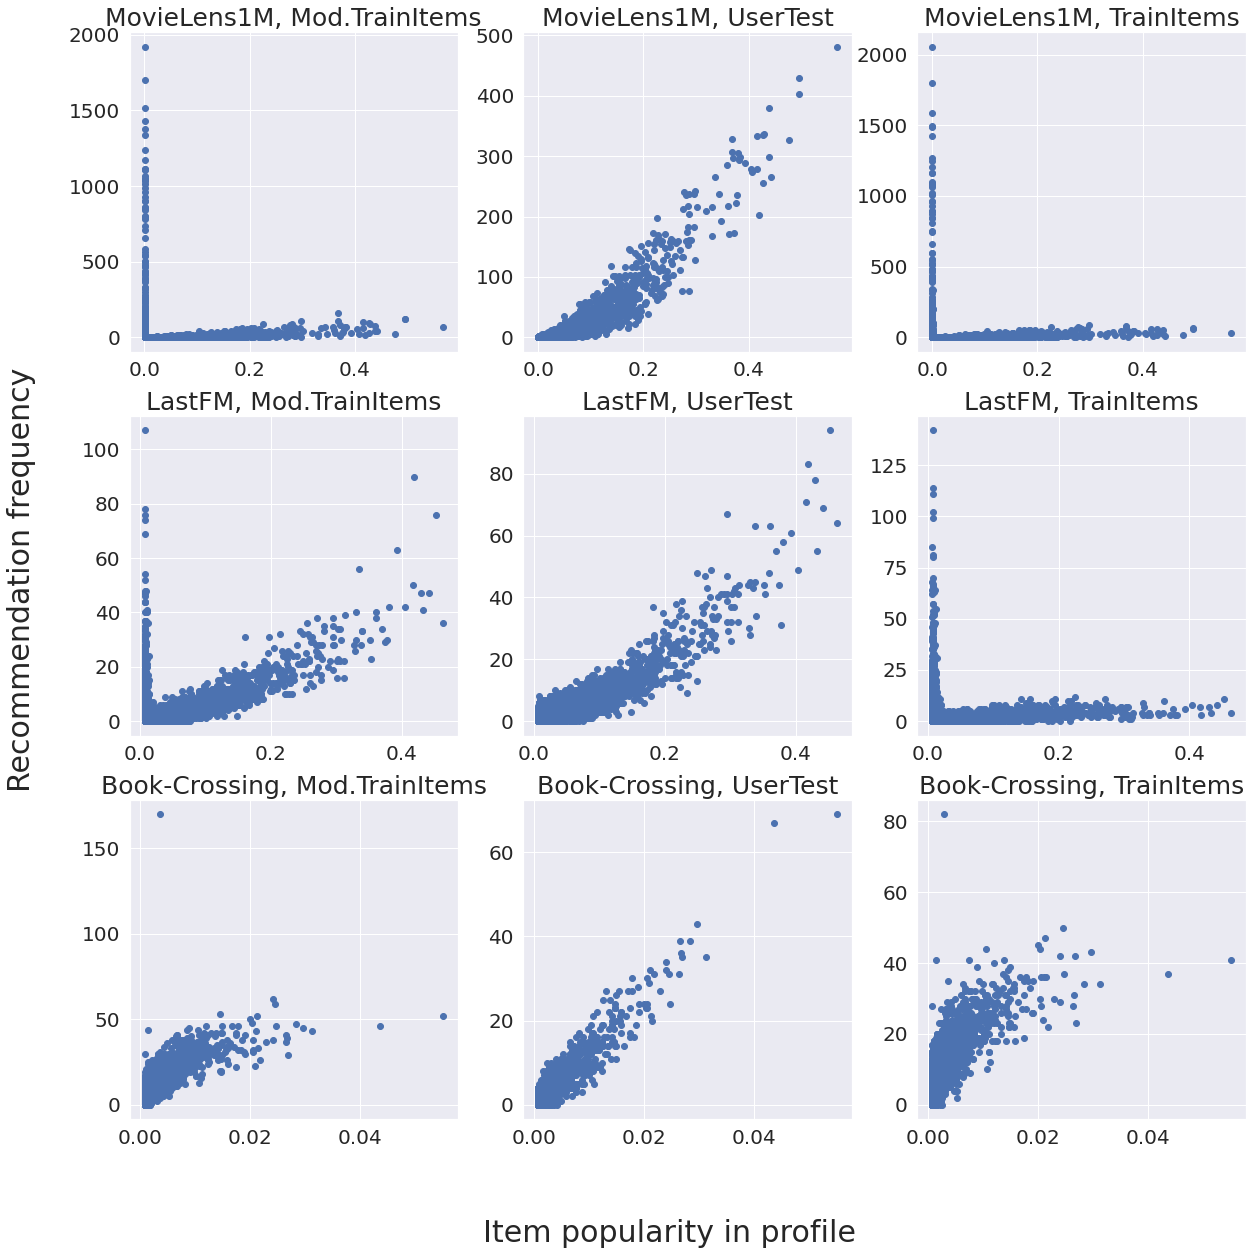

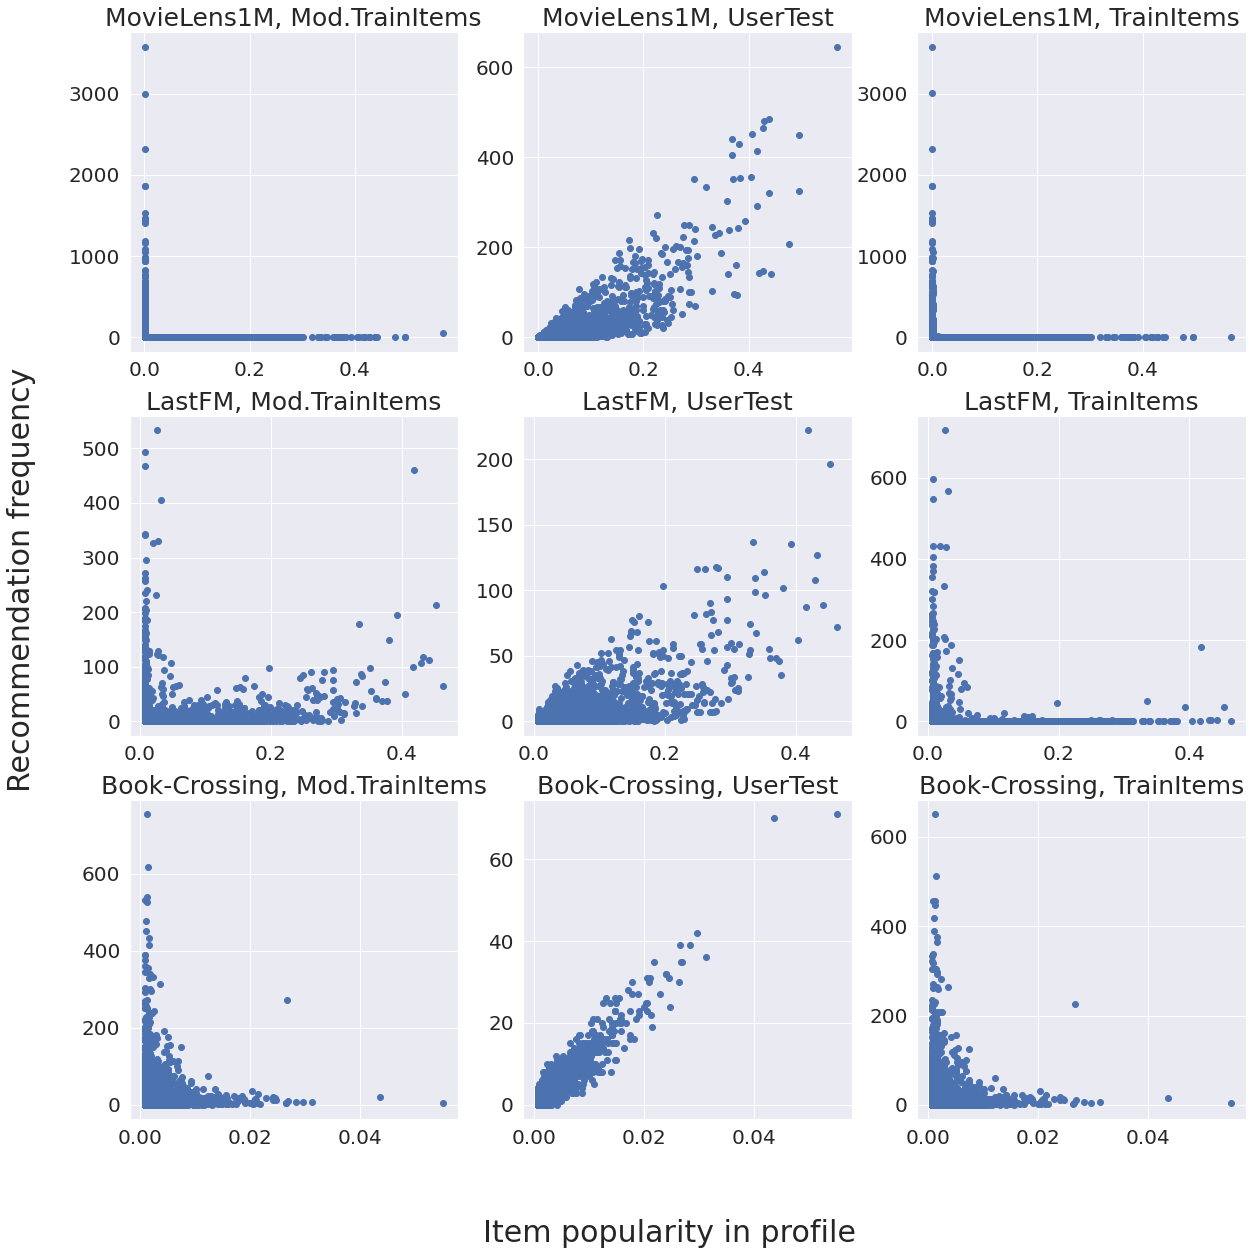

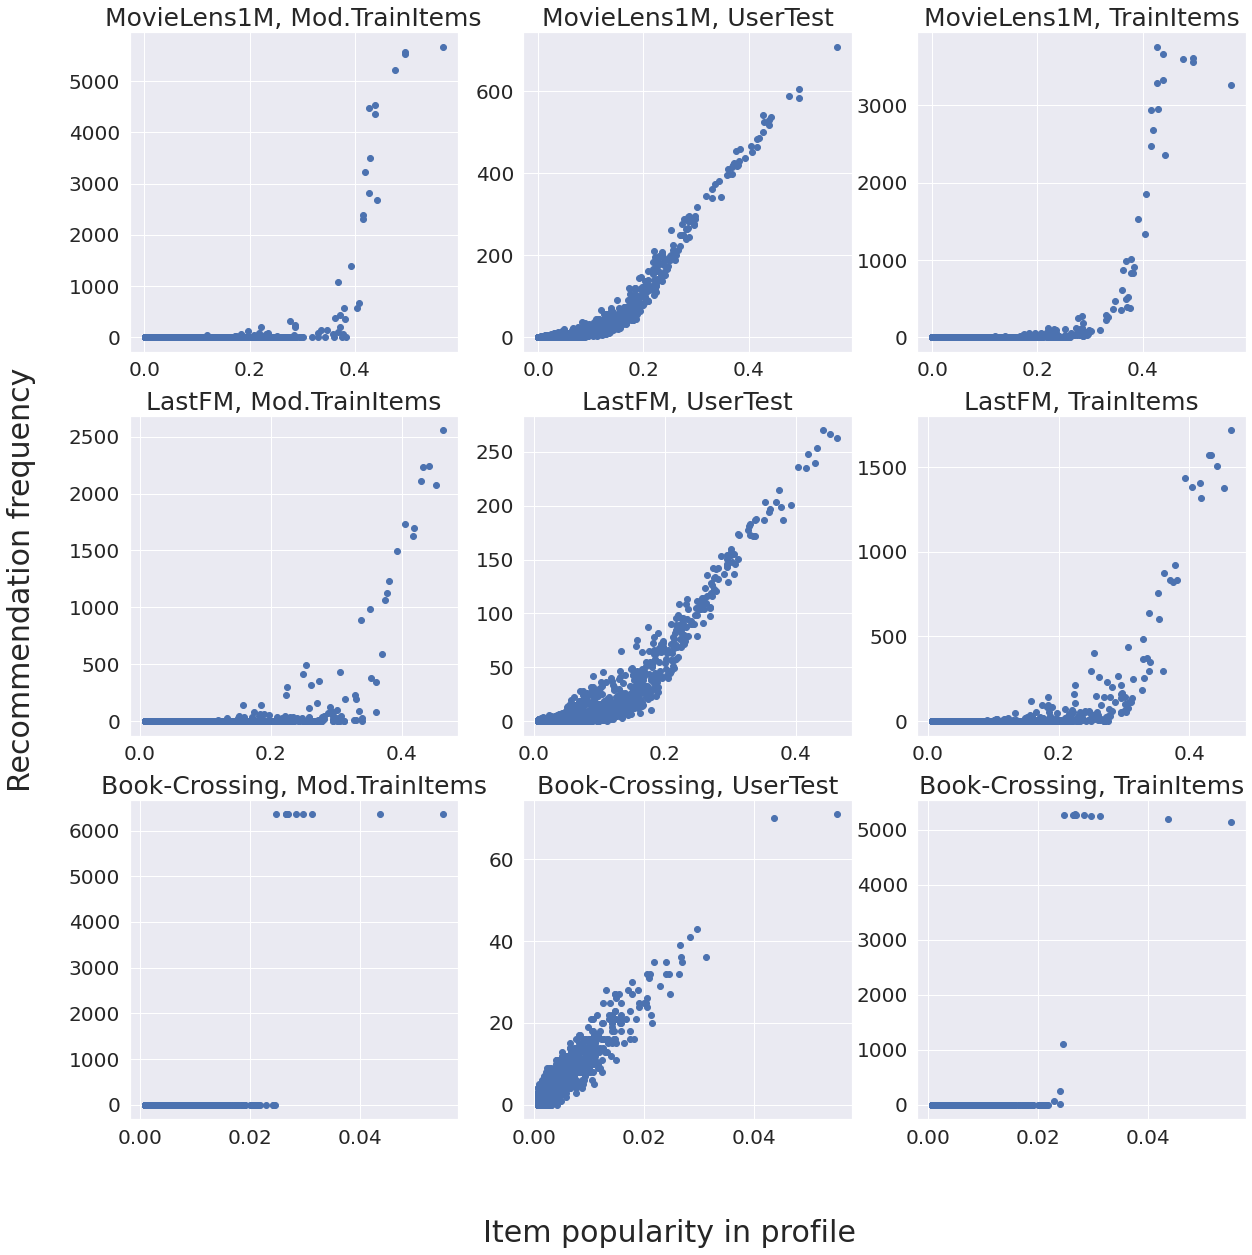

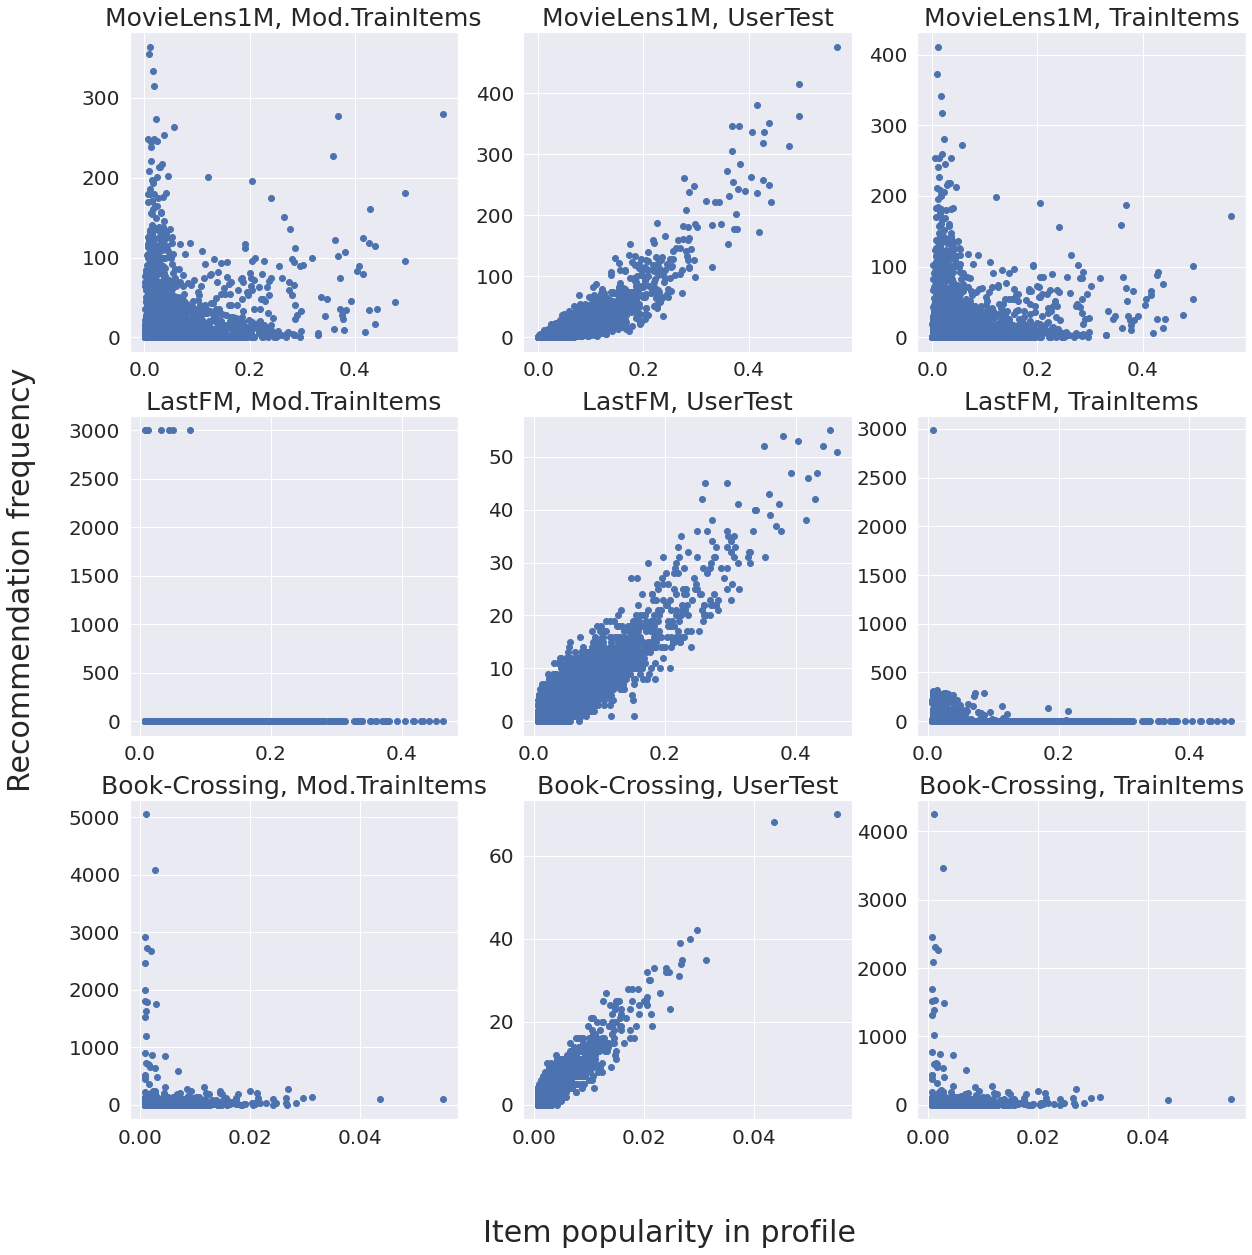

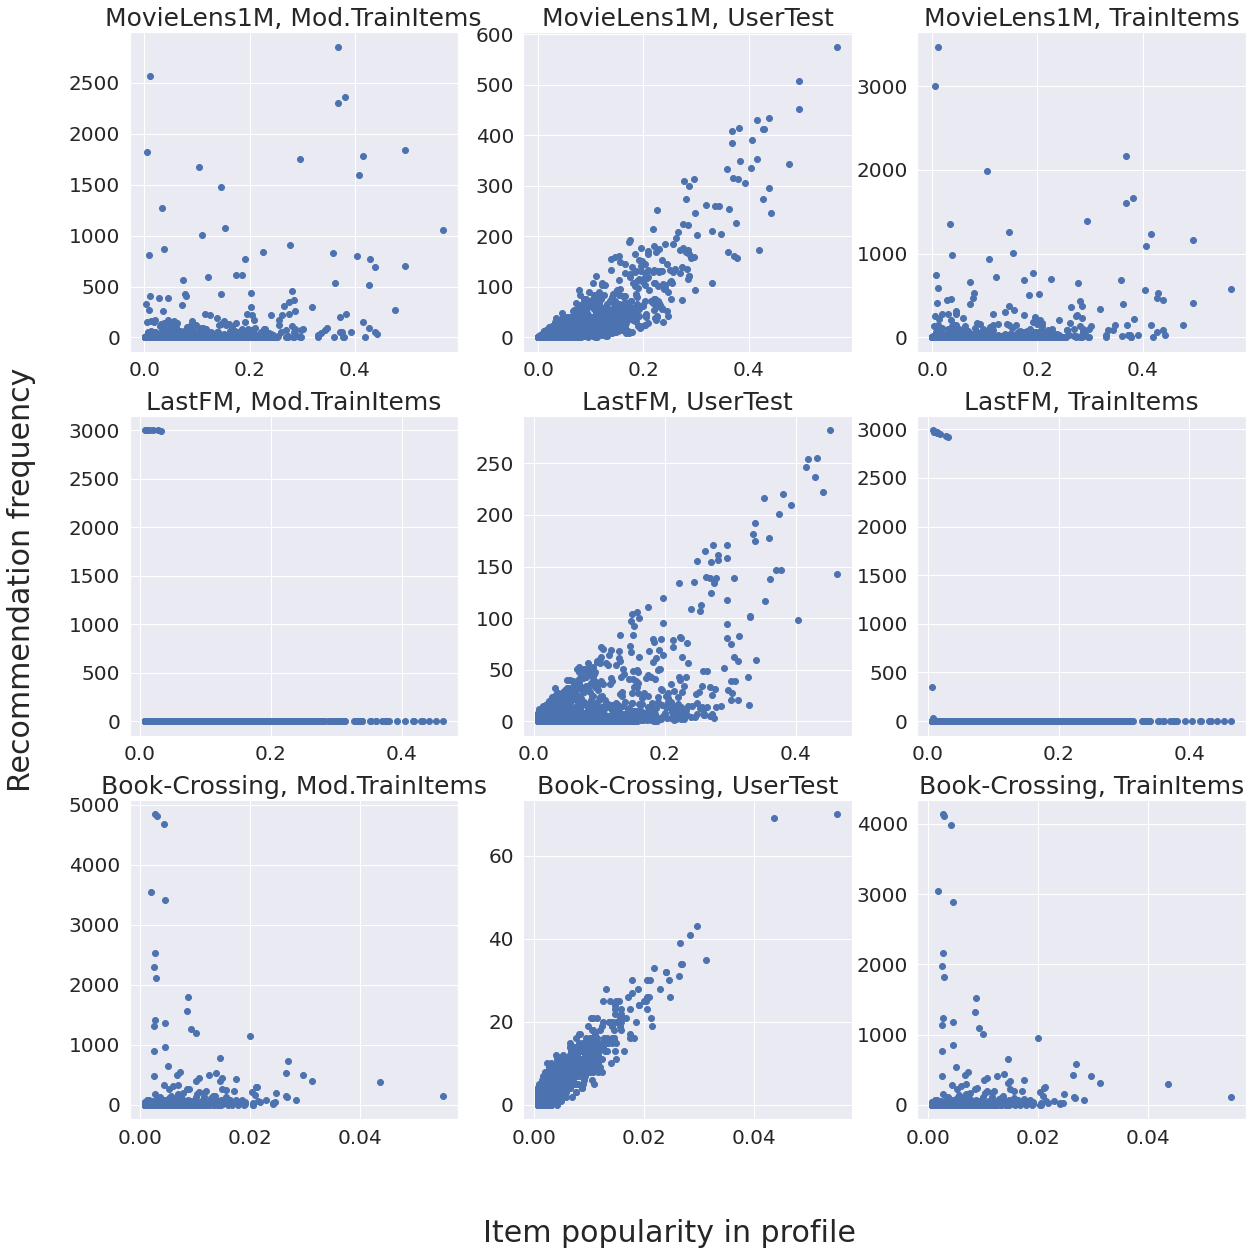

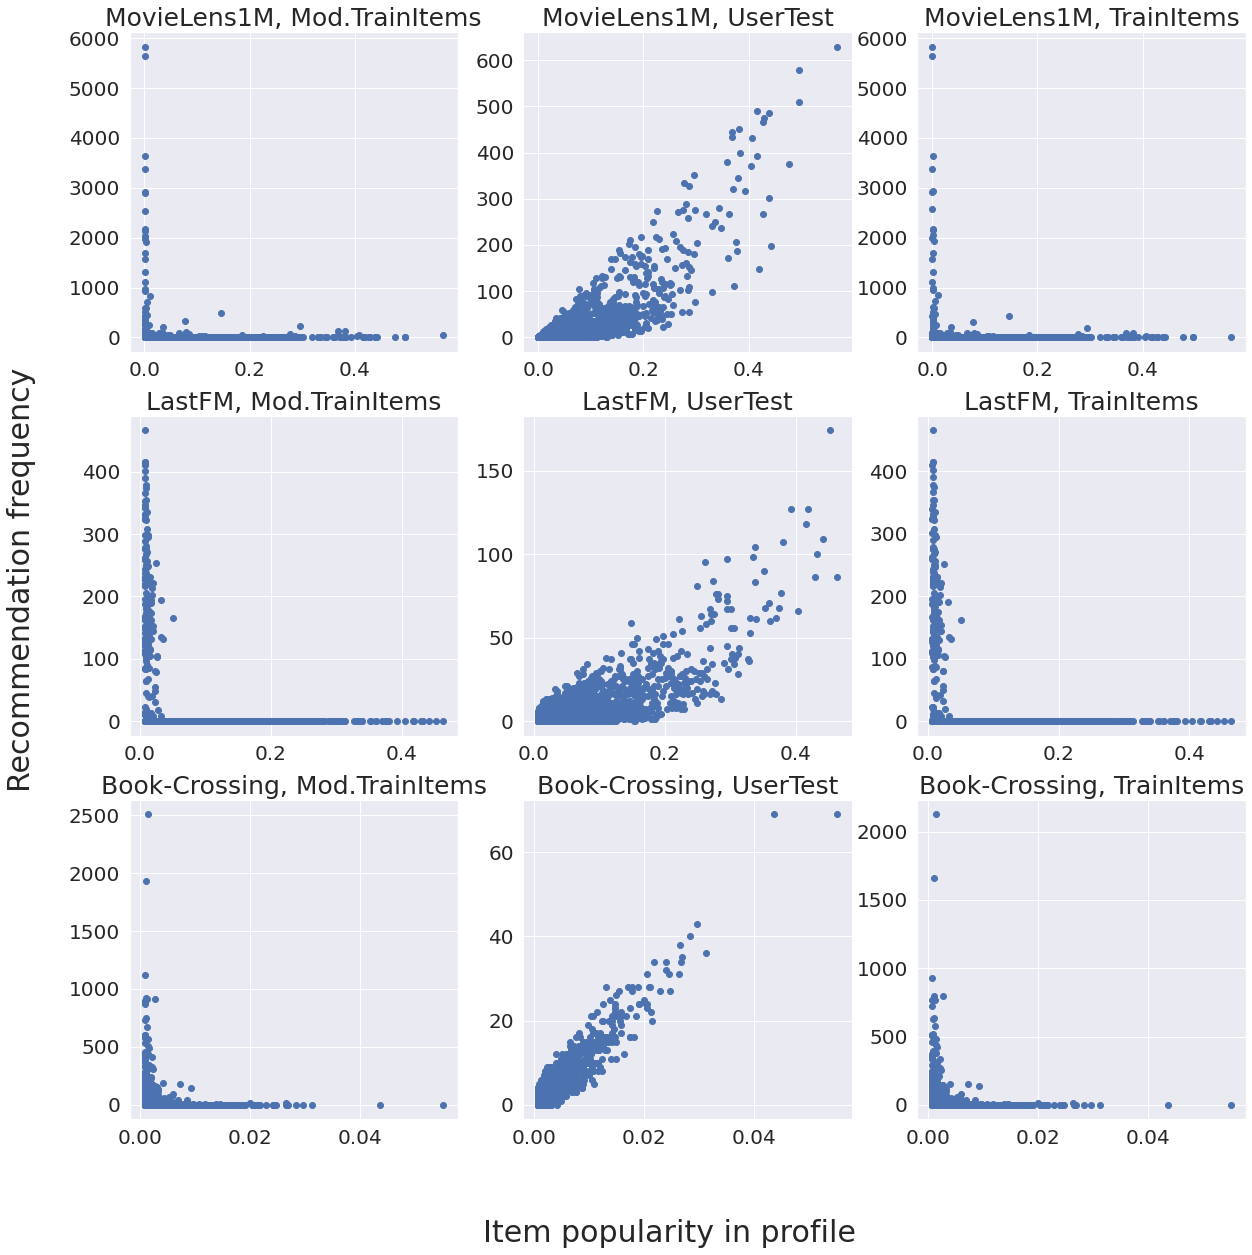

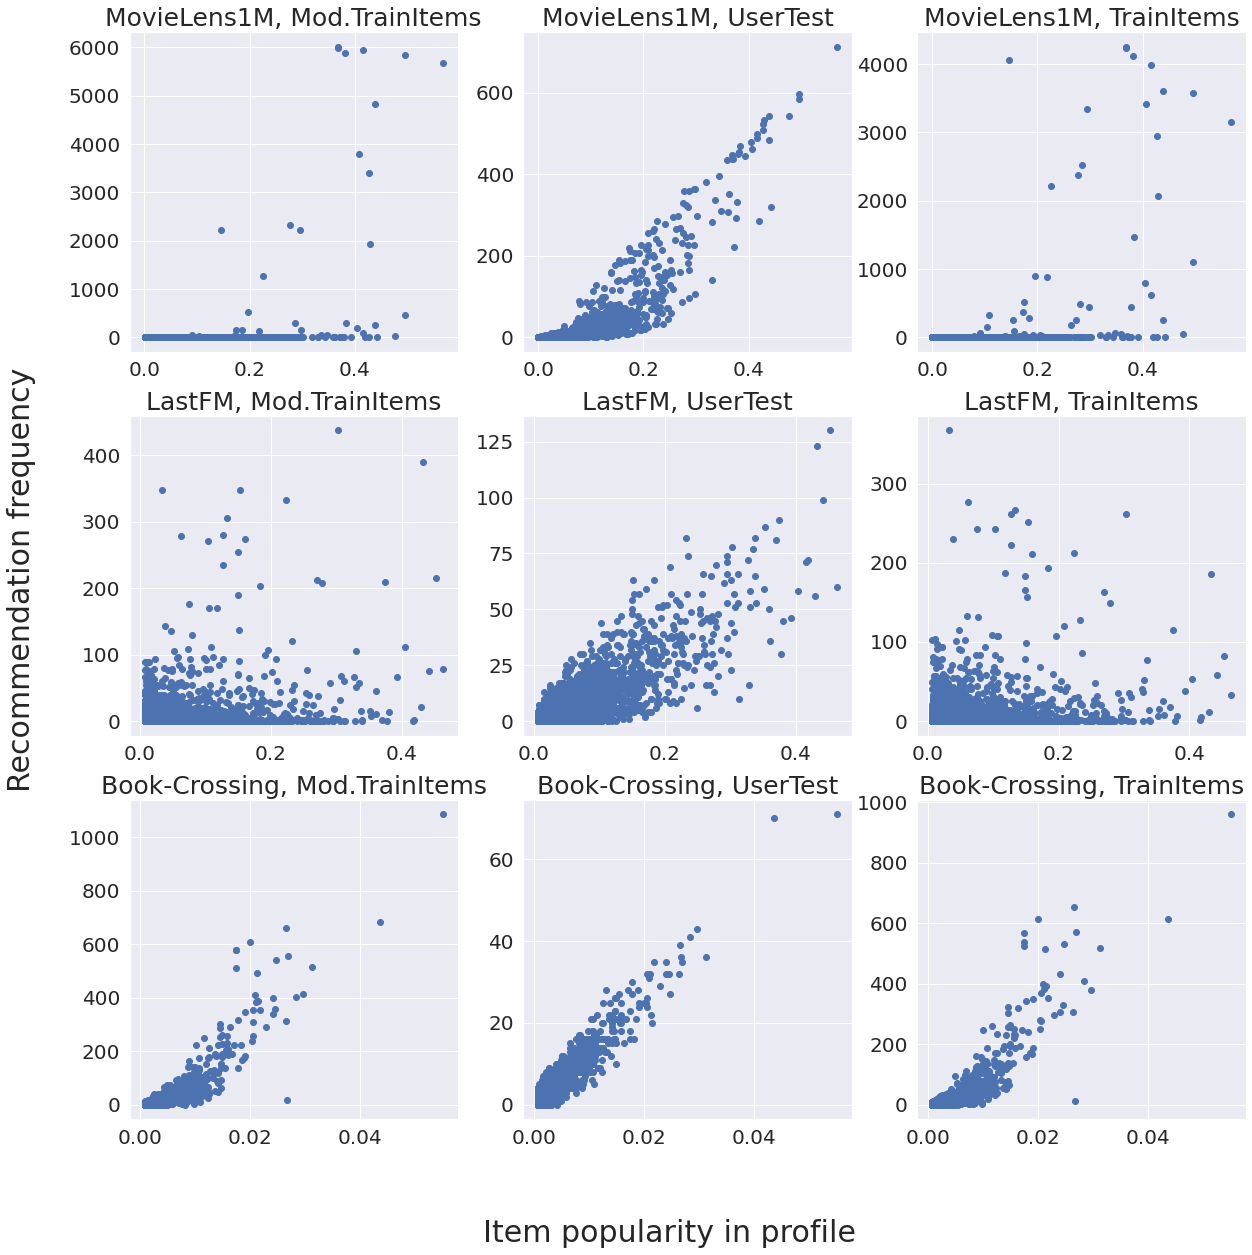

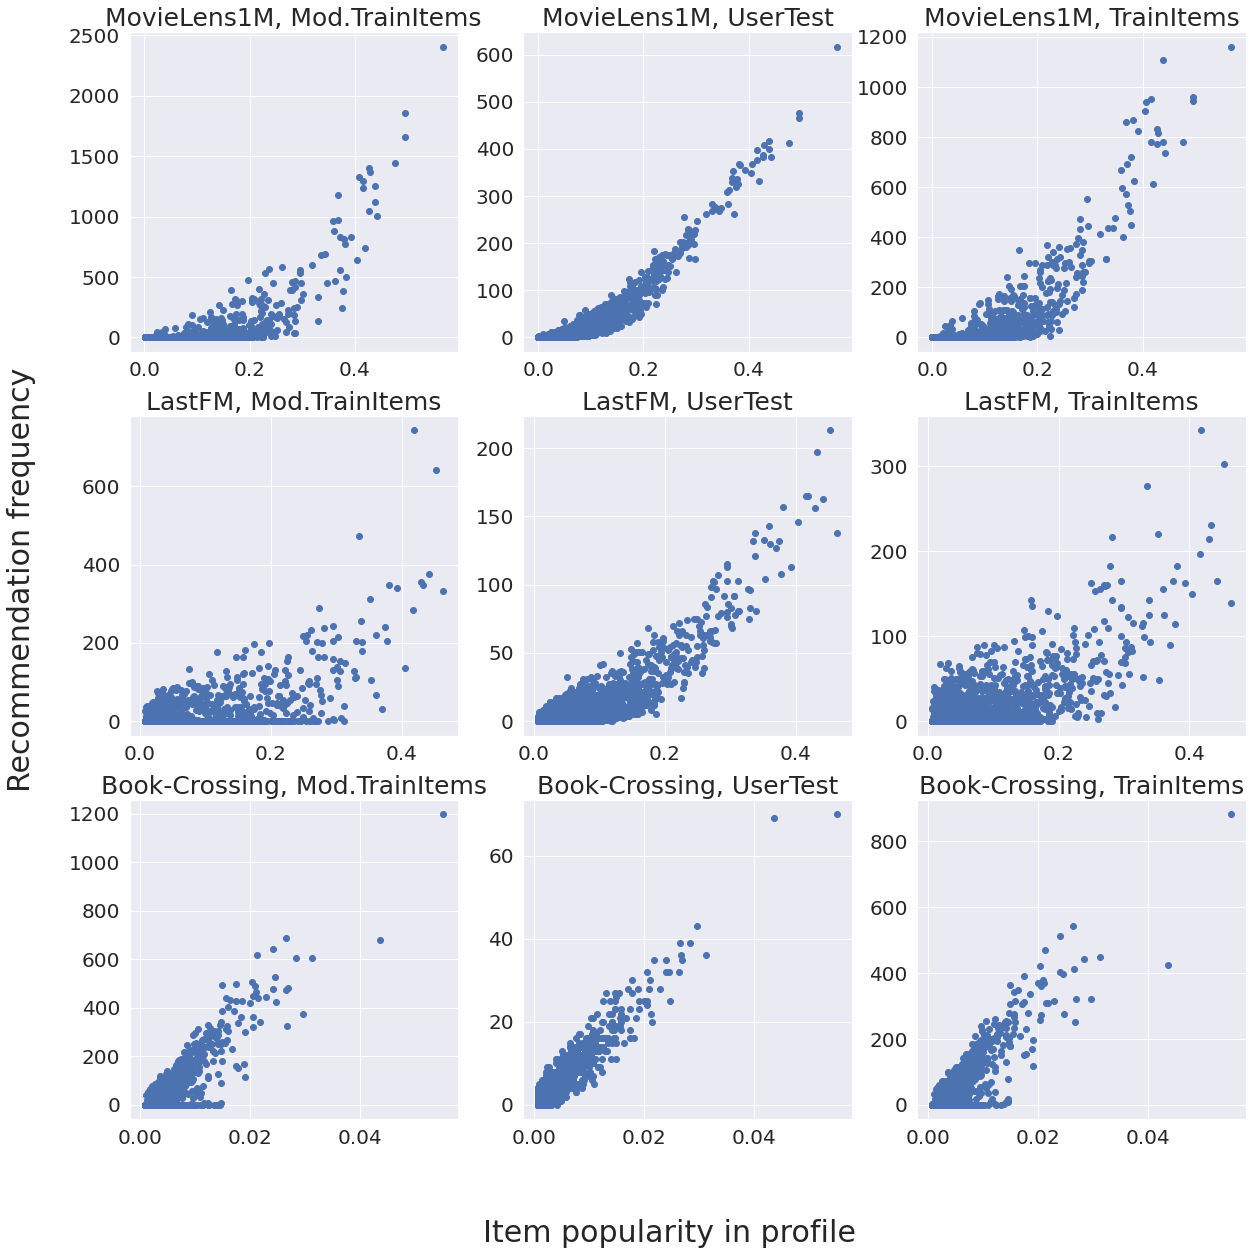

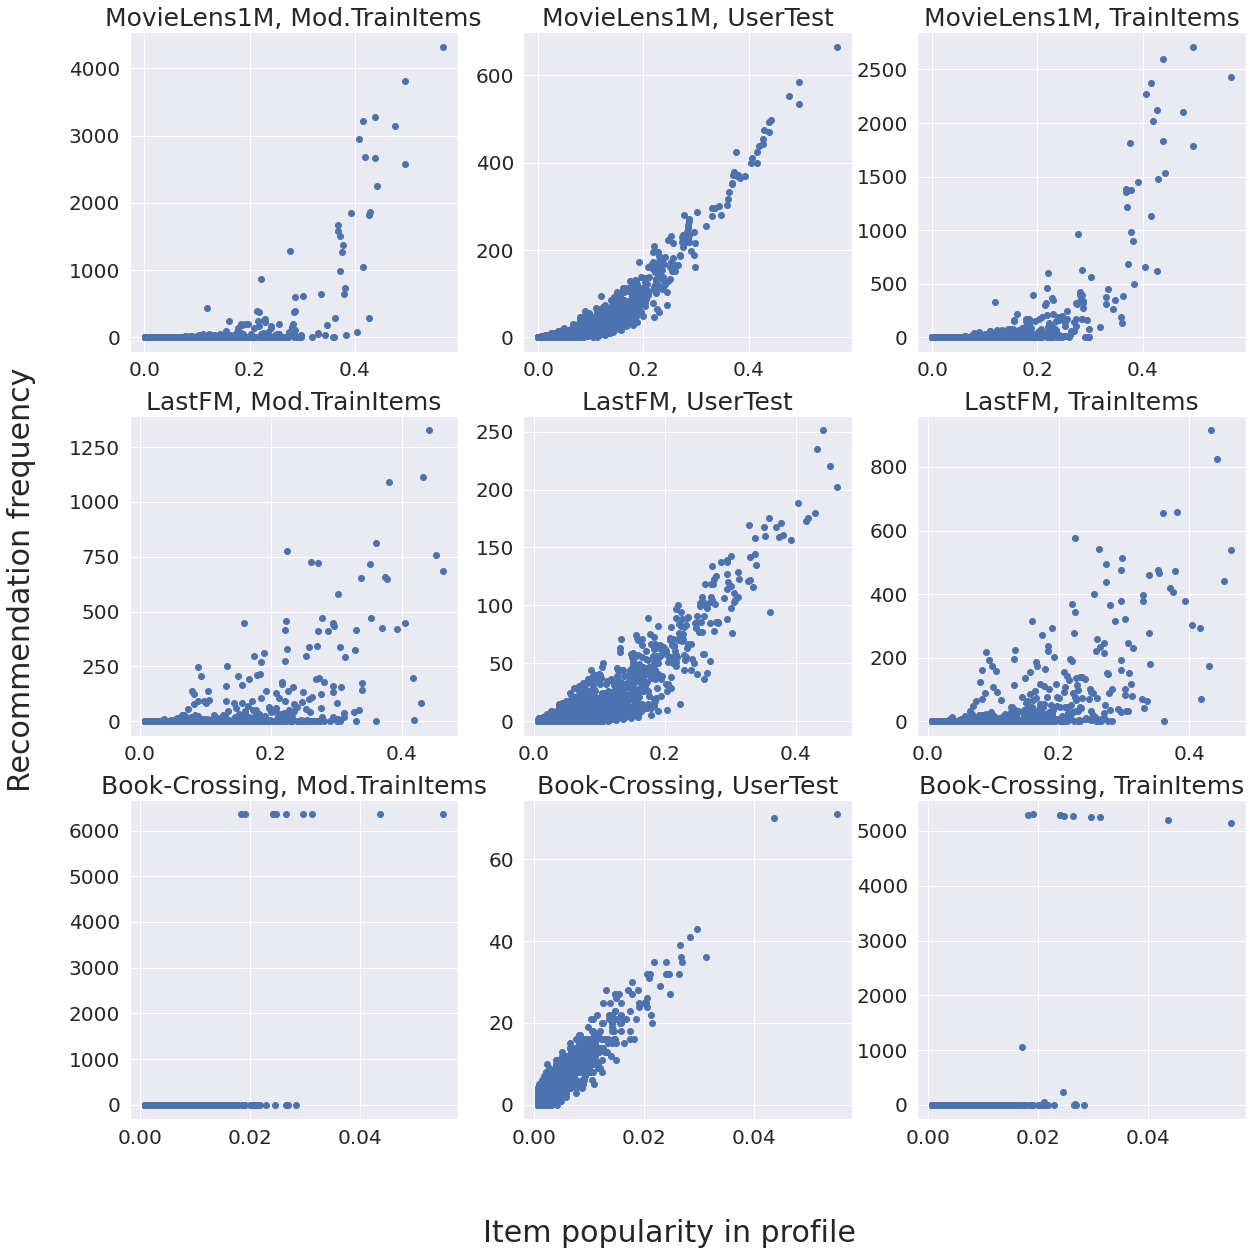

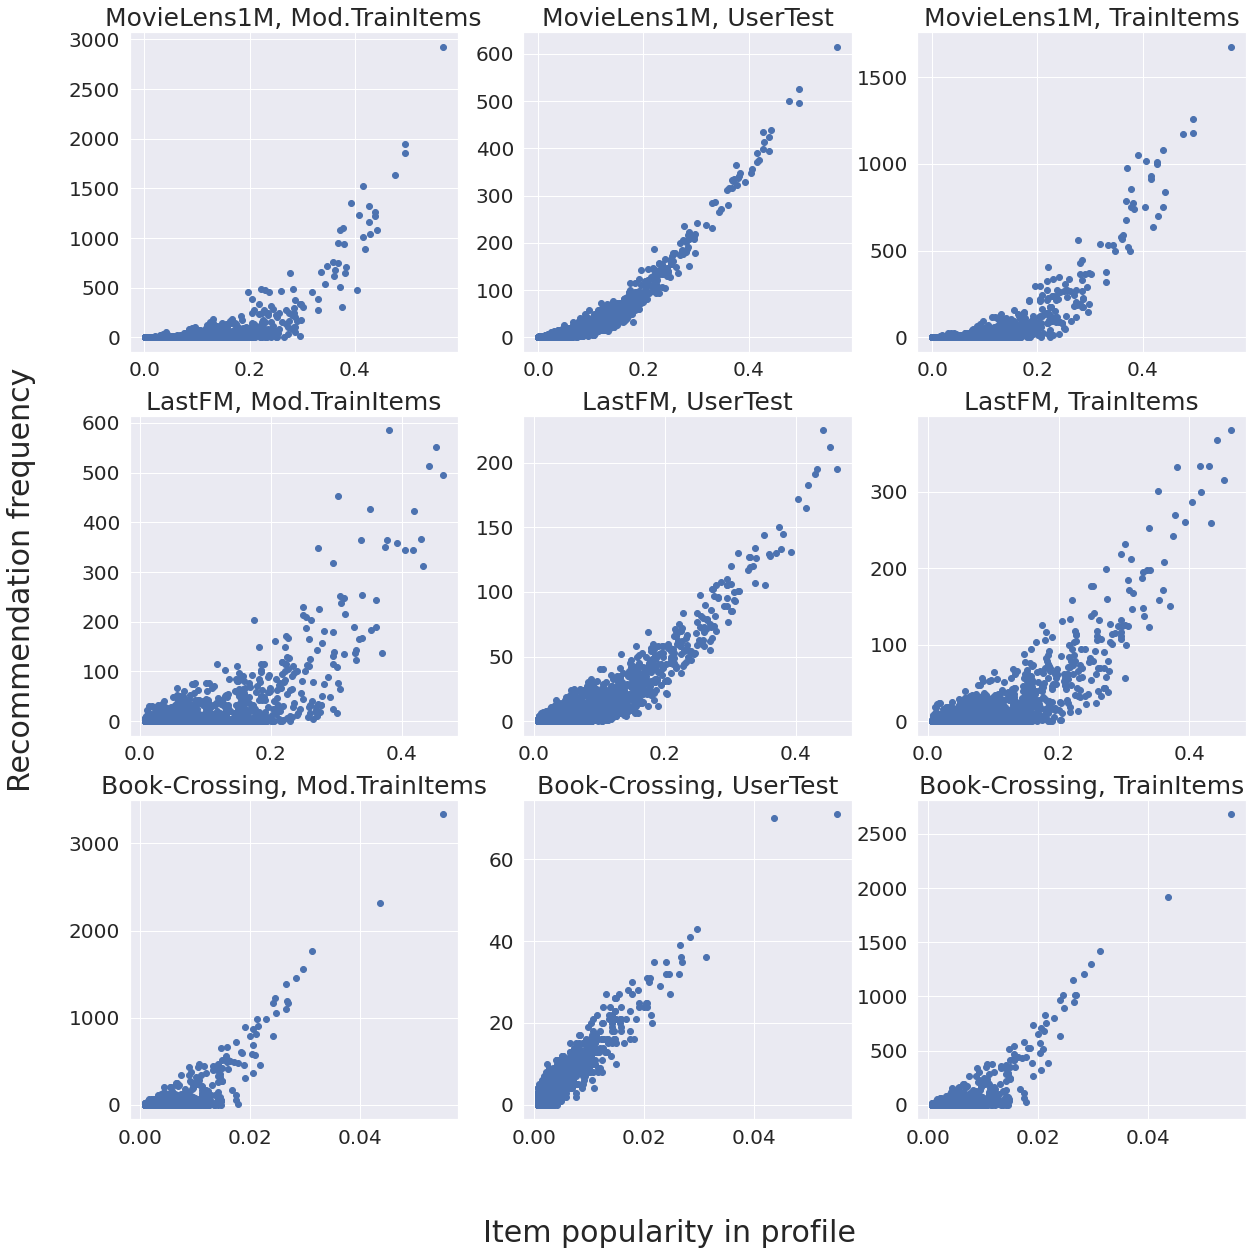

In [61]:
for algo in algo_names:
    fig, ax = plt.subplots(nrows=3, ncols=3)
    fig.set_figheight(20)
    fig.set_figwidth(20)

    fig.text(0.5, 0.04, 'Item popularity in profile', ha='center', fontsize='30')
    fig.text(0.04, 0.5, 'Recommendation frequency', va='center', rotation='vertical', fontsize='30')
    axes = ax.flatten()
    i=0
    for combi in some_combinations:
        data = combi[0]
        eva_str = combi[1]
        df = pd.read_csv(results_location+"df_item_dist_cornac_"+data+"_"+eva_str+".csv", index_col=0)
        profile_pop = df["count"]
        alg_pop = df[algo]
        correlation, _ = stats.pearsonr(profile_pop, alg_pop)
        axes[i].plot(profile_pop, alg_pop, "o")
        axes[i].set_title(data_dict[data] + ", "+eva_dict[eva_str], fontsize='25')
        i+=1
    plt.savefig("graphs/"+algo+"_results.png")
    plt.show()

# Second RQ

In [53]:
combi = all_combinations[0]
path = results_location+"low_gap_vals_"+combi[0]+"_"+combi[1]+"_"+combi[2]+".pickle"


In [54]:
pop_gaps = []
for p in pop_notion:
    for v in ["low","med","high"]:
        pop_gaps.append(p+"_"+v)

In [55]:
pop_gaps

['pop_one_low',
 'pop_one_med',
 'pop_one_high',
 'pop_two_low',
 'pop_two_med',
 'pop_two_high',
 'pop_three_low',
 'pop_three_med',
 'pop_three_high']

### Music

In [56]:
music_GAPs_eva1 = pd.DataFrame(columns=pop_gaps, index = algo_names).fillna(0)
music_GAPs_eva2 = pd.DataFrame(columns=pop_gaps, index = algo_names).fillna(0)
music_GAPs_eva3 = pd.DataFrame(columns=pop_gaps, index = algo_names).fillna(0)

In [57]:
for combi in all_combinations:
    if "music" in combi:
        eva_str = combi[1]
        pop_n = combi[2]
        path_low = results_location+"low_gap_vals_music_"+eva_str+"_"+pop_n+".pickle"
        path_med = results_location+"med_gap_vals_music_"+eva_str+"_"+pop_n+".pickle"
        path_high = results_location+"high_gap_vals_music_"+eva_str+"_"+pop_n+".pickle"
        low_gap_vals = pd.DataFrame([pkl.load(open(path_low,"rb") )[2:]], columns=algo_names)
        med_gap_vals = pd.DataFrame([pkl.load(open(path_med,"rb") )[2:]], columns=algo_names)
        high_gap_vals = pd.DataFrame([pkl.load(open(path_high,"rb") )[2:]], columns=algo_names)
        
        if eva_str=="eva_one":
            for algorithm in algo_names:
                music_GAPs_eva1.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                music_GAPs_eva1.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                music_GAPs_eva1.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]
                        
        elif eva_str=="eva_two":
            for algorithm in algo_names:
                music_GAPs_eva2.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                music_GAPs_eva2.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                music_GAPs_eva2.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]
            
        else:
            for algorithm in algo_names:
                music_GAPs_eva3.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                music_GAPs_eva3.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                music_GAPs_eva3.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]

In [59]:
np.round(music_GAPs_eva1,1)

,pop_one_low,pop_one_med,pop_one_high,pop_two_low,pop_two_med,pop_two_high,pop_three_low,pop_three_med,pop_three_high
UserKNN,-32.6,-32.6,-47.8,-27.6,-30.9,-52.7,-53.2,-28.2,-30.4
ItemKNN,-20.8,-13.4,-28.6,-17.0,-11.6,-33.3,-17.4,-13.6,-24.2
UserKNN with means,6.3,-6.4,-25.7,10.9,-4.7,-30.0,-34.7,-4.6,6.0
BPR,596.6,352.6,240.0,611.0,358.2,230.8,379.8,355.4,319.4
MF,-49.0,-68.9,-78.3,-47.1,-68.6,-79.1,-67.6,-68.1,-71.4
PMF,-69.7,-81.5,-87.1,-68.6,-81.3,-87.6,-80.8,-81.1,-83.1
NMF,-78.6,-87.1,-90.9,-77.8,-87.0,-91.1,-86.1,-86.8,-88.4
WMF,-2.8,14.2,1.2,0.6,17.8,-7.0,-30.4,20.0,32.5
HPF,150.4,143.8,125.2,166.0,148.6,110.1,93.2,153.2,167.6
NeuMF,399.1,242.3,157.3,399.6,243.9,159.2,262.2,239.0,213.4


In [62]:
music_GAPs_eva1.columns =["eva_one_"+x for x in music_GAPs_eva1.columns]
music_GAPs_eva2.columns =["eva_two_"+x for x in music_GAPs_eva2.columns]
music_GAPs_eva3.columns =["eva_three_"+x for x in music_GAPs_eva3.columns]

In [63]:
combined_music_GAPs = pd.concat([music_GAPs_eva1, music_GAPs_eva2, music_GAPs_eva3], axis=1)

In [65]:
combined_music_GAPs = np.round(combined_music_GAPs,1)

In [67]:
with open("latex_tables/music_GAPs_combined.tex", "w") as tf:
    tf.write(combined_music_GAPs.to_latex())

In [69]:
with open("latex_tables/music_GAPs_eva1.tex", "w") as tf:
    tf.write(np.round(music_GAPs_eva1,1).to_latex())
with open("latex_tables/music_GAPs_eva2.tex", "w") as tf:
    tf.write(np.round(music_GAPs_eva2,1).to_latex())
with open("latex_tables/music_GAPs_eva3.tex", "w") as tf:
    tf.write(np.round(music_GAPs_eva3,1).to_latex())

### Books

In [73]:
books_GAPs_eva1 = pd.DataFrame(columns=pop_gaps[:-3], index = algo_names).fillna(0)
books_GAPs_eva2 = pd.DataFrame(columns=pop_gaps[:-3], index = algo_names).fillna(0)
books_GAPs_eva3 = pd.DataFrame(columns=pop_gaps[:-3], index = algo_names).fillna(0)
for combi in all_combinations:
    if "books" in combi:
        eva_str = combi[1]
        pop_n = combi[2]
        path_low = results_location+"low_gap_vals_books_"+eva_str+"_"+pop_n+".pickle"
        path_med = results_location+"med_gap_vals_books_"+eva_str+"_"+pop_n+".pickle"
        path_high = results_location+"high_gap_vals_books_"+eva_str+"_"+pop_n+".pickle"
        low_gap_vals = pd.DataFrame([pkl.load(open(path_low,"rb") )[2:]], columns=algo_names)
        med_gap_vals = pd.DataFrame([pkl.load(open(path_med,"rb") )[2:]], columns=algo_names)
        high_gap_vals = pd.DataFrame([pkl.load(open(path_high,"rb") )[2:]], columns=algo_names)
        
        if eva_str=="eva_one":
            for algorithm in algo_names:
                books_GAPs_eva1.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                books_GAPs_eva1.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                books_GAPs_eva1.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]
                        
        elif eva_str=="eva_two":
            for algorithm in algo_names:
                books_GAPs_eva2.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                books_GAPs_eva2.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                books_GAPs_eva2.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]
            
        else:
            for algorithm in algo_names:
                books_GAPs_eva3.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                books_GAPs_eva3.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                books_GAPs_eva3.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]

In [74]:
books_GAPs_eva1

,pop_one_low,pop_one_med,pop_one_high,pop_two_low,pop_two_med,pop_two_high
UserKNN,25.2487,-54.5058,-73.2624,70.9276,-51.1751,-80.3198
ItemKNN,56.1647,-34.4437,-61.3080,109.4333,-28.1203,-72.4008
UserKNN with means,22.1253,-54.9305,-73.4937,67.2140,-51.4353,-80.8482
BPR,1118.9694,523.8554,295.2193,1434.7379,572.2700,228.3943
MF,22.9898,-23.8985,-57.7958,44.6767,-18.2631,-62.3604
PMF,186.1511,44.9508,-5.2485,252.9929,53.0784,-15.1389
NMF,-47.1272,-72.8368,-82.7174,-32.9785,-70.8432,-85.5686
WMF,39.0438,109.9239,81.4392,49.0890,118.9020,67.0285
HPF,283.5865,155.3489,91.2869,369.6912,168.3932,71.7007
NeuMF,1030.6557,478.6574,266.5858,1323.5469,523.5644,204.6023


In [75]:
books_GAPs_eva1.columns =["eva_one_"+x for x in books_GAPs_eva1.columns]
books_GAPs_eva2.columns =["eva_two_"+x for x in books_GAPs_eva2.columns]
books_GAPs_eva3.columns =["eva_three_"+x for x in books_GAPs_eva3.columns]

In [76]:
books_GAPs_eva1

,eva_one_pop_one_low,eva_one_pop_one_med,eva_one_pop_one_high,eva_one_pop_two_low,eva_one_pop_two_med,eva_one_pop_two_high
UserKNN,25.2487,-54.5058,-73.2624,70.9276,-51.1751,-80.3198
ItemKNN,56.1647,-34.4437,-61.3080,109.4333,-28.1203,-72.4008
UserKNN with means,22.1253,-54.9305,-73.4937,67.2140,-51.4353,-80.8482
BPR,1118.9694,523.8554,295.2193,1434.7379,572.2700,228.3943
MF,22.9898,-23.8985,-57.7958,44.6767,-18.2631,-62.3604
PMF,186.1511,44.9508,-5.2485,252.9929,53.0784,-15.1389
NMF,-47.1272,-72.8368,-82.7174,-32.9785,-70.8432,-85.5686
WMF,39.0438,109.9239,81.4392,49.0890,118.9020,67.0285
HPF,283.5865,155.3489,91.2869,369.6912,168.3932,71.7007
NeuMF,1030.6557,478.6574,266.5858,1323.5469,523.5644,204.6023


In [77]:
with open("latex_tables/books_GAPs_eva1.tex", "w") as tf:
    tf.write(np.round(books_GAPs_eva1,1).to_latex())
with open("latex_tables/books_GAPs_eva2.tex", "w") as tf:
    tf.write(np.round(books_GAPs_eva2,1).to_latex())
with open("latex_tables/books_GAPs_eva3.tex", "w") as tf:
    tf.write(np.round(books_GAPs_eva3,1).to_latex())

### Movies

In [92]:
movies_GAPs_eva1 = pd.DataFrame(columns=pop_gaps[:-3], index = algo_names).fillna(0)
movies_GAPs_eva2 = pd.DataFrame(columns=pop_gaps[:-3], index = algo_names).fillna(0)
movies_GAPs_eva3 = pd.DataFrame(columns=pop_gaps[:-3], index = algo_names).fillna(0)
for combi in all_combinations:
    if "movies" in combi:
        eva_str = combi[1]
        pop_n = combi[2]
        path_low = results_location+"low_gap_vals_movies_"+eva_str+"_"+pop_n+".pickle"
        path_med = results_location+"med_gap_vals_movies_"+eva_str+"_"+pop_n+".pickle"
        path_high = results_location+"high_gap_vals_movies_"+eva_str+"_"+pop_n+".pickle"
        low_gap_vals = pd.DataFrame([pkl.load(open(path_low,"rb") )[2:]], columns=algo_names)
        med_gap_vals = pd.DataFrame([pkl.load(open(path_med,"rb") )[2:]], columns=algo_names)
        high_gap_vals = pd.DataFrame([pkl.load(open(path_high,"rb") )[2:]], columns=algo_names)
        
        if eva_str=="eva_one":
            for algorithm in algo_names:
                movies_GAPs_eva1.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                movies_GAPs_eva1.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                movies_GAPs_eva1.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]
                        
        elif eva_str=="eva_two":
            for algorithm in algo_names:
                movies_GAPs_eva2.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                movies_GAPs_eva2.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                movies_GAPs_eva2.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]
            
        else:
            for algorithm in algo_names:
                movies_GAPs_eva3.at[algorithm, pop_n+"_low"] = low_gap_vals[algorithm][0]
                movies_GAPs_eva3.at[algorithm, pop_n+"_med"] = med_gap_vals[algorithm][0]
                movies_GAPs_eva3.at[algorithm, pop_n+"_high"] = high_gap_vals[algorithm][0]

In [93]:
movies_GAPs_eva1.columns =["eva_one_"+x for x in movies_GAPs_eva1.columns]
movies_GAPs_eva2.columns =["eva_two_"+x for x in movies_GAPs_eva2.columns]
movies_GAPs_eva3.columns =["eva_three_"+x for x in movies_GAPs_eva3.columns]

In [94]:
movies_GAPs_eva3

,eva_three_pop_one_low,eva_three_pop_one_med,eva_three_pop_one_high,eva_three_pop_two_low,eva_three_pop_two_med,eva_three_pop_two_high
UserKNN,-99.5484,-99.6872,-99.7602,-99.5407,-99.6832,-99.7681
ItemKNN,-60.6197,-82.9439,-97.1015,-52.4235,-83.7445,-98.5698
UserKNN with means,-99.5799,-99.7152,-99.7901,-99.5696,-99.7112,-99.7992
BPR,269.9329,170.1527,108.9213,274.3657,174.2339,101.4751
MF,-45.1403,-62.9024,-70.7027,-42.2919,-62.4925,-72.4650
PMF,45.5115,16.5913,2.9640,45.4986,15.4986,-6.5877
NMF,-93.0218,-95.2554,-96.1663,-93.0138,-95.1441,-96.3484
WMF,215.6487,129.4689,79.2923,220.3063,133.1679,71.9845
HPF,104.3257,82.9136,59.9872,108.7818,83.4322,57.7976
NeuMF,187.8243,133.4493,93.5356,191.2450,136.0481,88.4178


In [95]:
with open("latex_tables/movies_GAPs_eva1.tex", "w") as tf:
    tf.write(np.round(movies_GAPs_eva1,1).to_latex())
with open("latex_tables/movies_GAPs_eva2.tex", "w") as tf:
    tf.write(np.round(movies_GAPs_eva2,1).to_latex())
with open("latex_tables/movies_GAPs_eva3.tex", "w") as tf:
    tf.write(np.round(movies_GAPs_eva3,1).to_latex())